# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [ ]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

In [ ]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [ ]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    print("Number of sequences: ", len(X_dna_seqs_train))
    print("Length of each sequence: ", len(X_dna_seqs_train[1]))

    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train))) # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [] # use count_cpgs here to generate labels with temp generated in step2
    for seq in temp:
      y_dna_seqs.append(count_cpgs(seq))

    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

Number of sequences:  2048
Length of each sequence:  128
Number of sequences:  512
Length of each sequence:  128


In [ ]:
# We use the hyperparameters that performed best during grid search. Please refer below for hyperparameter tuning using grid search.

LSTM_HIDDEN = 32
LSTM_LAYER = 2
batch_size = 32
learning_rate = 0.001
epoch_num = 30

In [ ]:
# create data loader
from torch.utils.data import DataLoader, TensorDataset

train_x = np.array(train_x, dtype='float32')
train_y = np.array(train_y, dtype='float32')

X_train_tensors = torch.tensor(train_x)
y_train_tensor = torch.tensor(train_y)

test_x = np.array(test_x, dtype='float32')
test_y = np.array(test_y, dtype='float32')

X_test_tensors = torch.tensor(test_x)
y_test_tensor = torch.tensor(test_y)

train_dataset = TensorDataset(X_train_tensors, y_train_tensor)
test_dataset = TensorDataset(X_test_tensors, y_test_tensor)


In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_data_loader =  DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
# Model
import torch.nn as nn
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = nn.LSTM(input_size = 1, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYER, batch_first=True, dropout=0.2)
        self.classifier = nn.Linear(LSTM_HIDDEN, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.classifier(x)
        return x

In [ ]:
# init model / loss function / optimizer etc.

import torch.optim as optim

model = CpGPredictor()
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# training (you can modify the code below)
t_loss = 0.0
model.train()
model.zero_grad()
for epoch in range(epoch_num):
    for batch in train_data_loader:
        #TODO complete training loop

        optimizer.zero_grad()
        predictions = model(batch[:][0].view(-1,128,1)).reshape(-1)
        loss = loss_fn(predictions, batch[:][1])
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        t_loss += loss.item()

    average_loss = t_loss / len(train_data_loader)
    print("Loss at epoch %d:  %f" % (epoch, average_loss))
    t_loss = 0.0

Loss at epoch 0:  5.041046
Loss at epoch 1:  4.877913
Loss at epoch 2:  4.316019
Loss at epoch 3:  3.093313
Loss at epoch 4:  2.323822
Loss at epoch 5:  1.997702
Loss at epoch 6:  1.801232
Loss at epoch 7:  1.753254
Loss at epoch 8:  1.732764
Loss at epoch 9:  1.712920
Loss at epoch 10:  1.689852
Loss at epoch 11:  1.670661
Loss at epoch 12:  1.648898
Loss at epoch 13:  1.627034
Loss at epoch 14:  1.613419
Loss at epoch 15:  1.611334
Loss at epoch 16:  1.613016
Loss at epoch 17:  1.612373
Loss at epoch 18:  1.612582
Loss at epoch 19:  1.612829
Loss at epoch 20:  1.612126
Loss at epoch 21:  1.612226
Loss at epoch 22:  1.612626
Loss at epoch 23:  1.611981
Loss at epoch 24:  1.611962
Loss at epoch 25:  1.611711
Loss at epoch 26:  1.611943
Loss at epoch 27:  1.610866
Loss at epoch 28:  1.611636
Loss at epoch 29:  1.611711


In [ ]:
# eval (you can modify the code below)
model.eval()

res_gs = []
res_pred = []

total_test_loss = 0.0

for batch in test_data_loader:
  with torch.no_grad():
        y_pred = model(batch[:][0].view(-1,128,1)).reshape(-1)
        test_loss = loss_fn(y_pred, batch[:][1])
        total_test_loss += test_loss.item()

        res_gs.extend(batch[:][1].tolist())
        res_pred.extend(y_pred.tolist())
average_test_loss = total_test_loss / len(test_data_loader)
print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 1.5740425288677216


In [ ]:
print("Ground Truth Y: ", res_gs)
print("Predicted Y: ", res_pred)

Ground Truth Y:  [4.0, 3.0, 7.0, 4.0, 2.0, 5.0, 7.0, 5.0, 5.0, 6.0, 4.0, 9.0, 5.0, 6.0, 4.0, 4.0, 4.0, 3.0, 5.0, 5.0, 3.0, 6.0, 5.0, 3.0, 4.0, 6.0, 5.0, 7.0, 5.0, 6.0, 3.0, 3.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 6.0, 7.0, 4.0, 4.0, 5.0, 6.0, 6.0, 6.0, 5.0, 6.0, 4.0, 4.0, 6.0, 3.0, 5.0, 5.0, 10.0, 4.0, 5.0, 1.0, 8.0, 5.0, 4.0, 5.0, 6.0, 3.0, 4.0, 2.0, 8.0, 4.0, 6.0, 3.0, 8.0, 3.0, 4.0, 5.0, 6.0, 7.0, 7.0, 3.0, 4.0, 0.0, 8.0, 6.0, 4.0, 3.0, 6.0, 7.0, 4.0, 5.0, 6.0, 7.0, 1.0, 5.0, 3.0, 4.0, 9.0, 5.0, 3.0, 4.0, 3.0, 7.0, 3.0, 10.0, 6.0, 8.0, 2.0, 5.0, 9.0, 5.0, 5.0, 2.0, 6.0, 4.0, 7.0, 6.0, 5.0, 2.0, 4.0, 4.0, 7.0, 4.0, 5.0, 4.0, 2.0, 8.0, 6.0, 5.0, 5.0, 8.0, 5.0, 8.0, 6.0, 6.0, 5.0, 2.0, 4.0, 4.0, 9.0, 2.0, 6.0, 10.0, 5.0, 6.0, 3.0, 4.0, 8.0, 7.0, 2.0, 8.0, 5.0, 6.0, 3.0, 8.0, 6.0, 5.0, 6.0, 10.0, 1.0, 7.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0, 7.0, 4.0, 6.0, 3.0, 4.0, 8.0, 3.0, 5.0, 1.0, 5.0, 5.0, 8.0, 4.0, 5.0, 6.0, 9.0, 6.0, 9.0, 7.0, 5.0, 9.0, 3.0, 5.0, 7.0, 2.0, 7.0, 4.0, 10.0, 7.0, 6.0, 7.0, 10

In [ ]:
# TODO complete evaluation of the model

from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Regression Metrics")

print("Mean Absolute Error: ", mean_absolute_error(res_gs, res_pred))
print("Mean Squared Error ", mean_squared_error(res_gs, res_pred))

# We can also treat it as a classification problem and compute precision, recall F1 scores

from sklearn.metrics import precision_score, recall_score
res_gs = [int(round(val)) for val in res_gs]
res_pred = [int(round(val)) for val in res_pred]

precision = precision_score(res_gs, res_pred, average='micro')
print("Precision: ", precision)
recall = recall_score(res_gs, res_pred, average='micro')
print("Recall: ", recall)

Regression Metrics
Mean Absolute Error:  1.5740425577387214
Mean Squared Error  4.158162673604535
Precision:  0.208984375
Recall:  0.208984375


### **HyperParameter tuning using Grid Search**

We use a grid search approach to try all possible combinations of the give hyper parameters:
* Batch Sizes = 16, 32
* Learning Rates = 0.0001, 0.00005
* Hidden Layers = 16, 32
* LSTM Layers = 1, 2
* Dropout options= True, False
* Loss Functions = MSE Loss, MAE Loss

We choose the best hyperparameter setting based on train and test losses observed.

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.194066835567355
Average Test Loss: 4.162956867367029


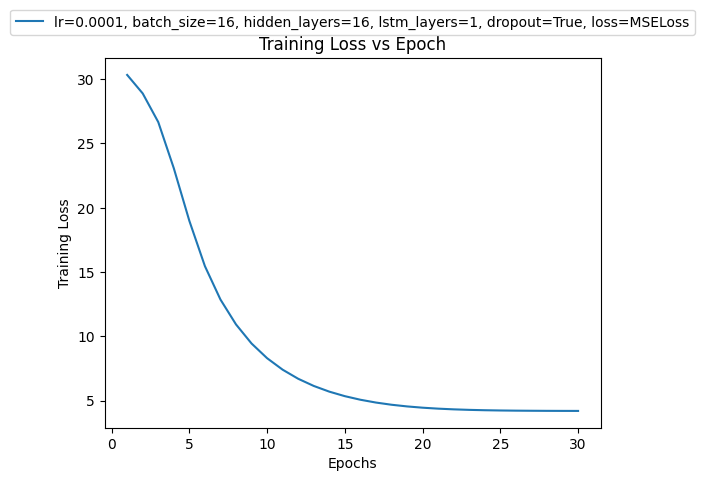

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6113636367954314
Average Test Loss: 1.5772008448839188


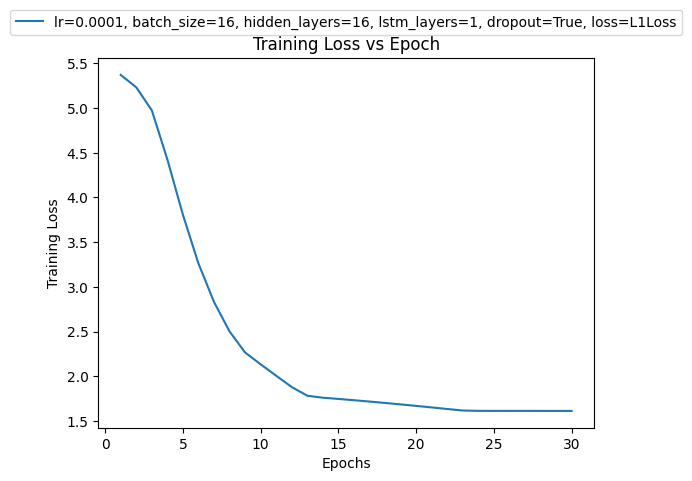

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.1921175587922335
Average Test Loss: 4.170092578977346


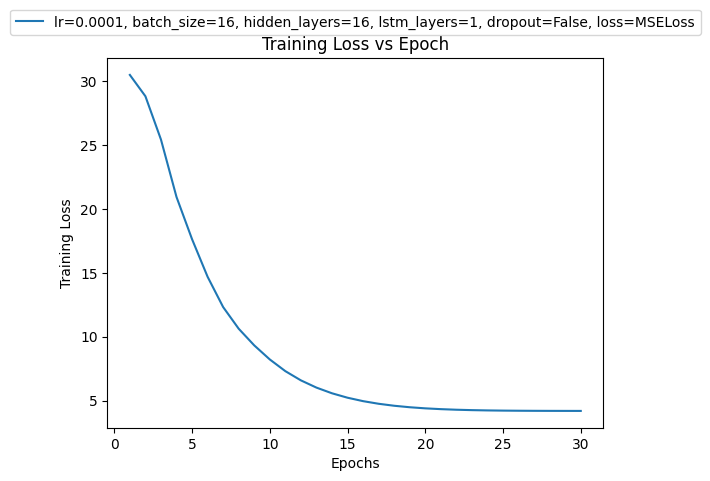

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6114370664581656
Average Test Loss: 1.577401801943779


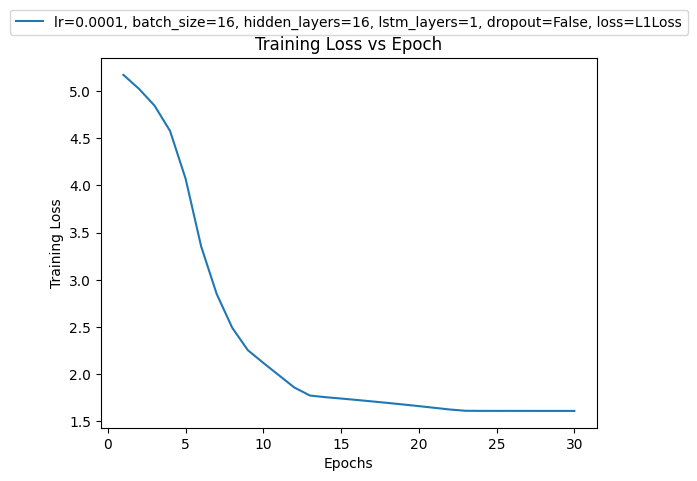

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.1925759660080075
Average Test Loss: 4.157679989933968


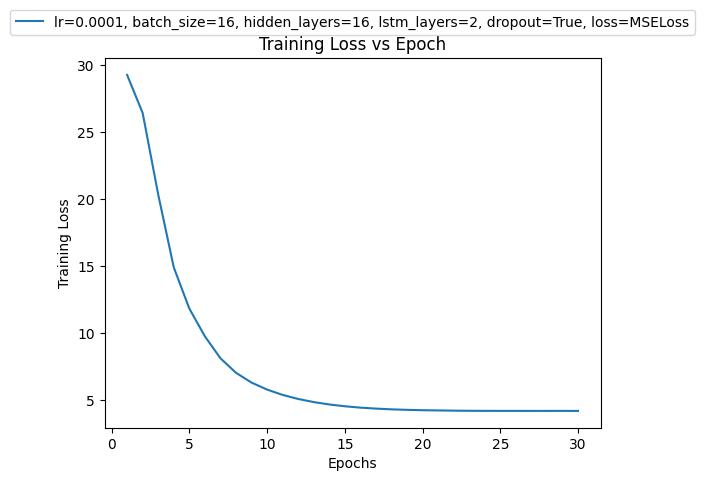

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6109333699569106
Average Test Loss: 1.5725052300840616


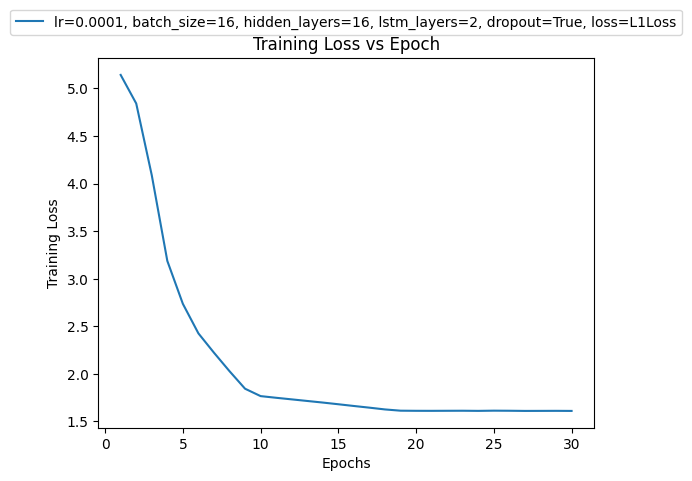

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.192514582537115
Average Test Loss: 4.157955147325993


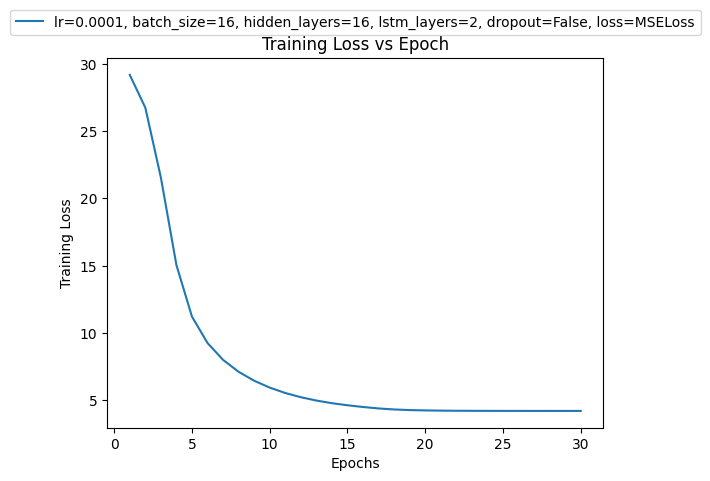

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6081442199647427
Average Test Loss: 1.572778107598424


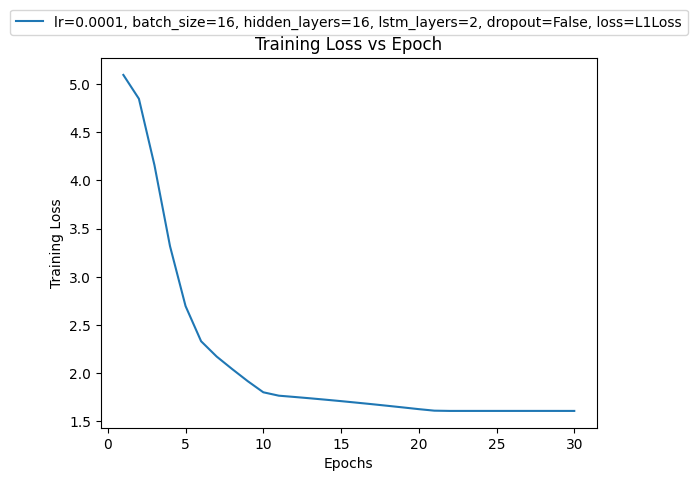

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.151796968653798
Average Test Loss: 4.172902524471283


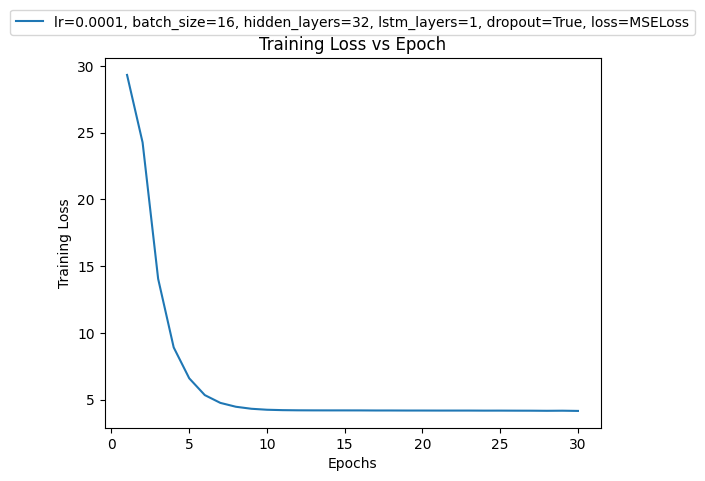

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6086481139063835
Average Test Loss: 1.5729989409446716


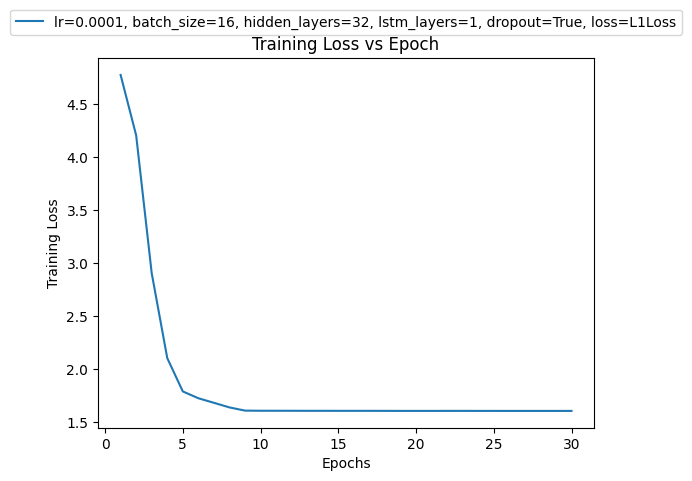

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.191799846477807
Average Test Loss: 4.162975750863552


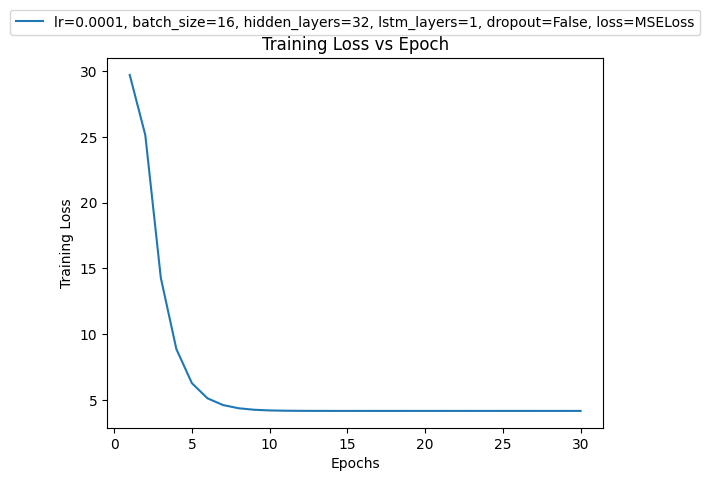

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6086703706532717
Average Test Loss: 1.572757937014103


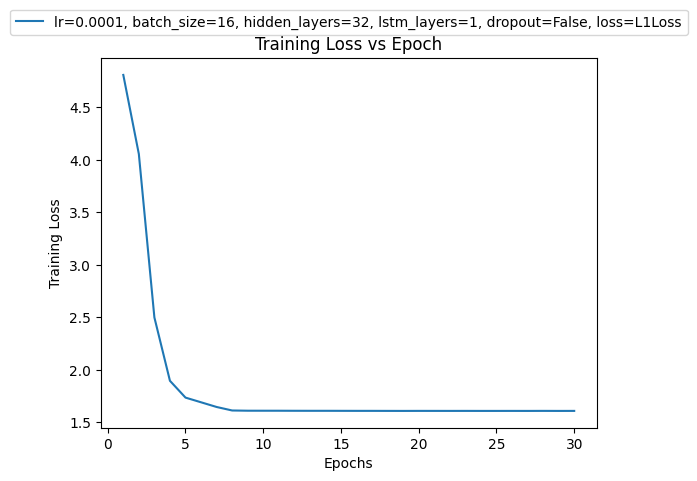

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.187807318754494
Average Test Loss: 4.165403038263321


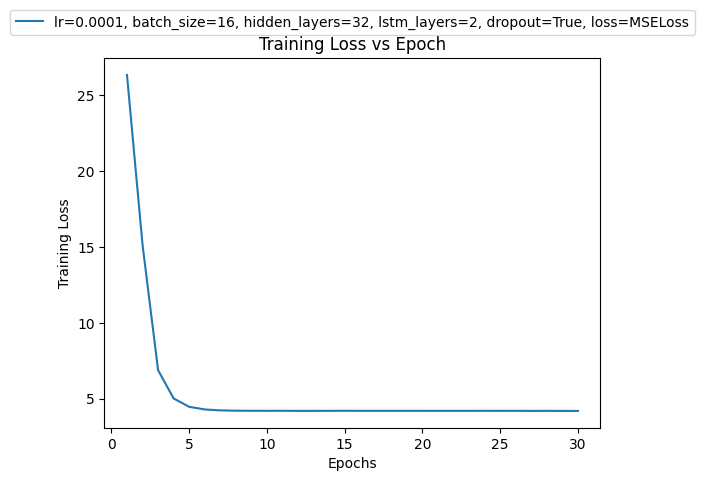

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6106130718253553
Average Test Loss: 1.5728981271386147


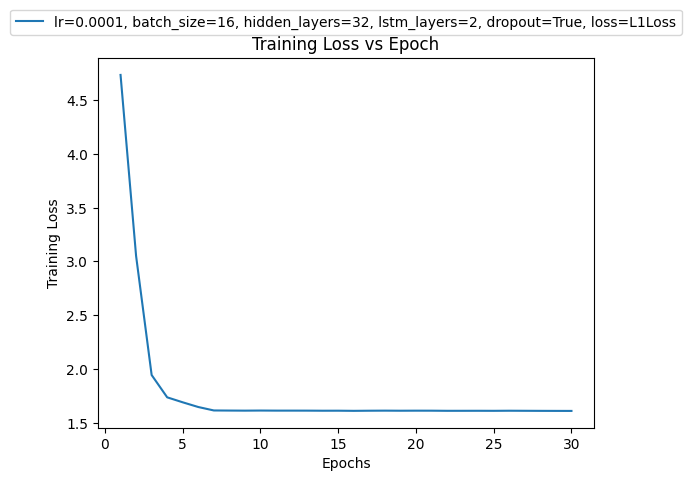

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.192856301553547
Average Test Loss: 4.157930634915829


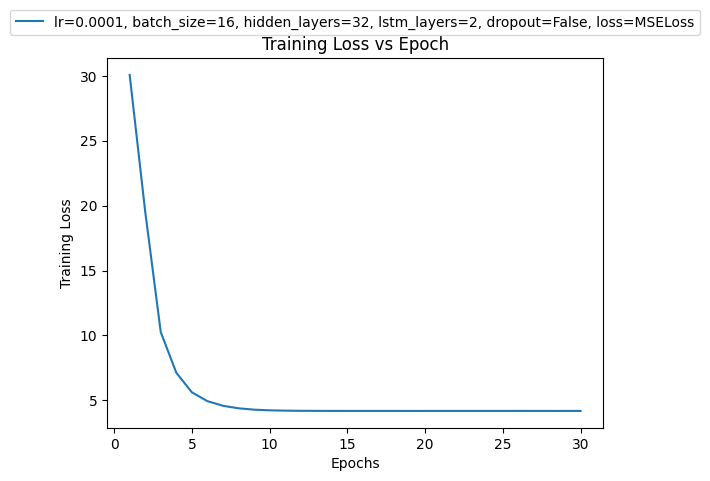

Epochs: 30, Learning Rate: 0.0001, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.608268196694553
Average Test Loss: 1.5725515950471163


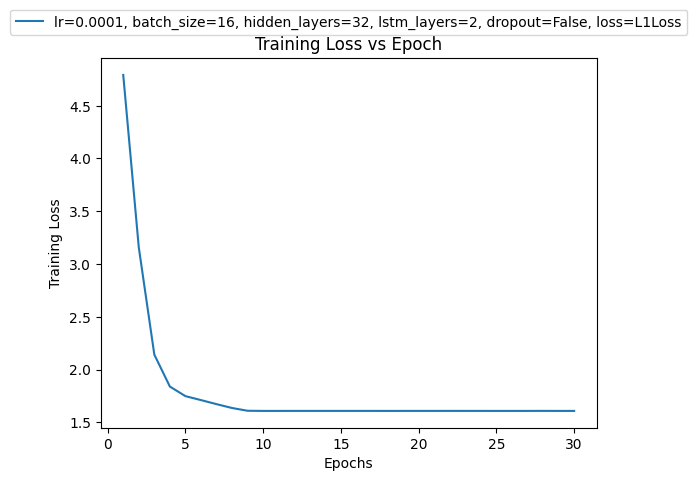

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.830931792035699
Average Test Loss: 4.701301634311676


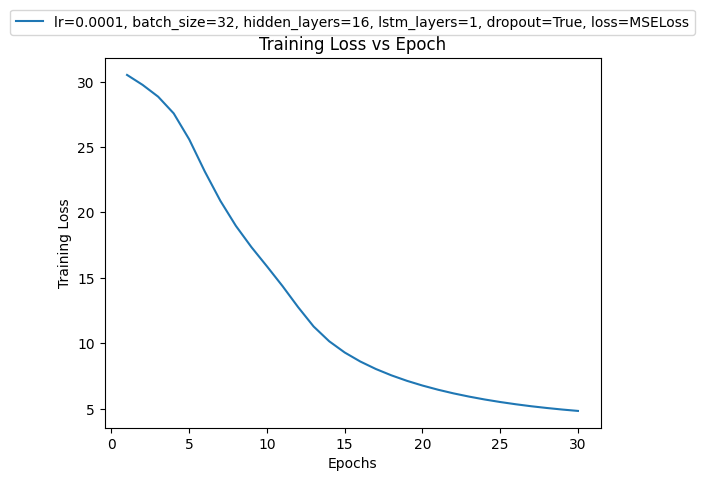

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.7255005408078432
Average Test Loss: 1.692995935678482


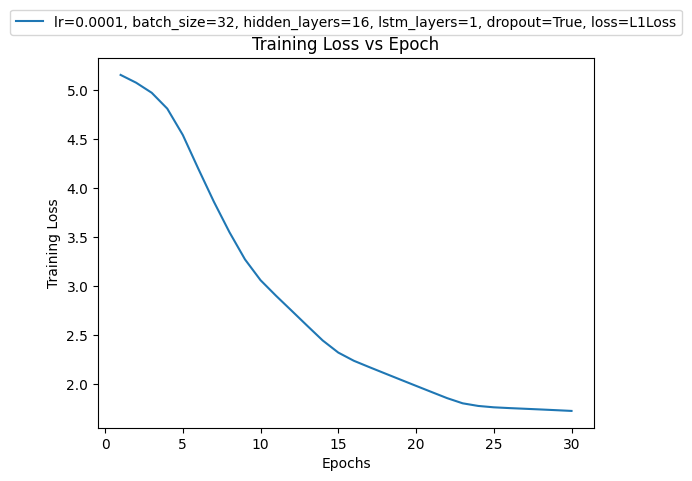

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.632745079696178
Average Test Loss: 4.519100874662399


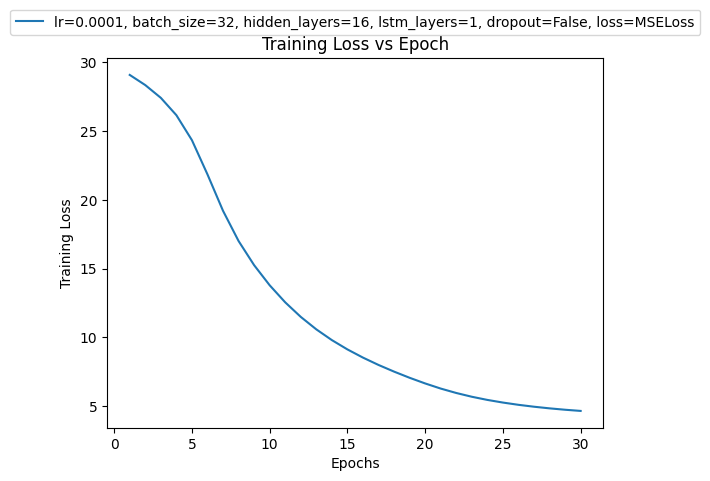

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.67815906368196
Average Test Loss: 1.6408495232462883


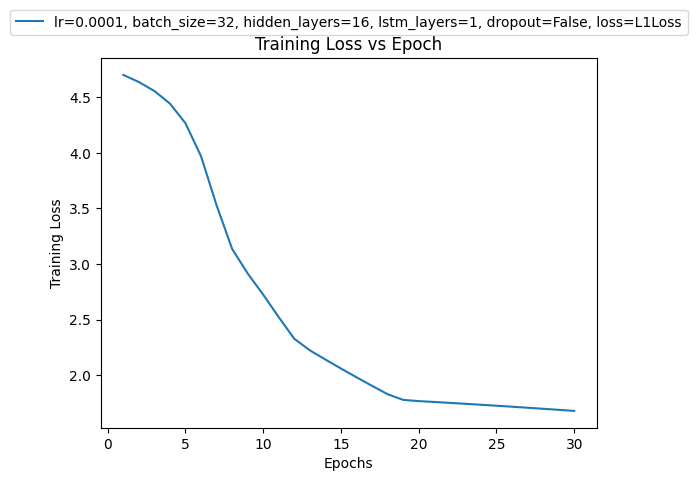

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.813716694712639
Average Test Loss: 4.668410375714302


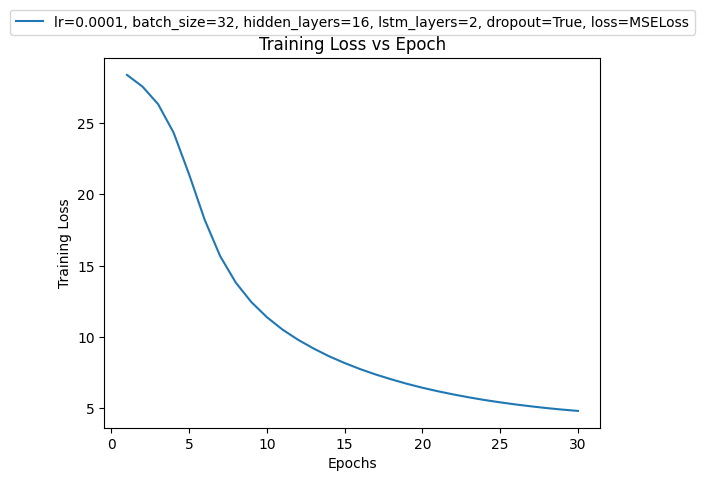

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6480917986482382
Average Test Loss: 1.6072992160916328


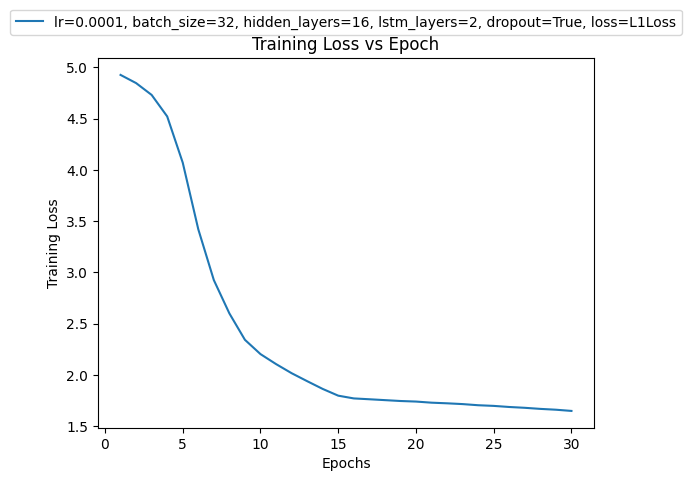

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.353449359536171
Average Test Loss: 4.275627706199884


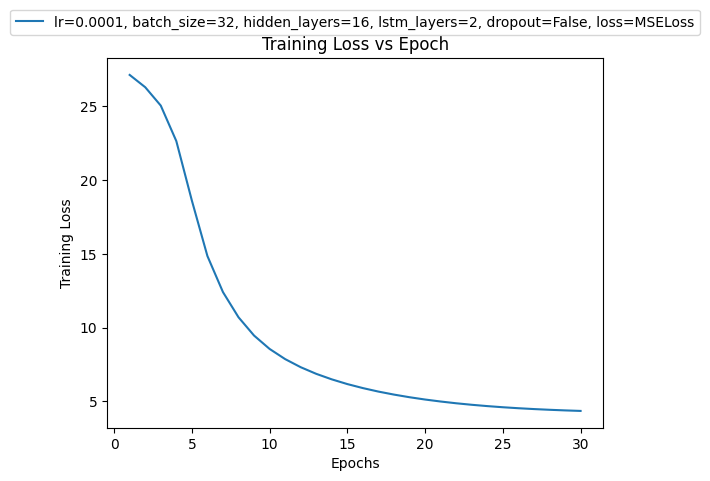

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.7330057062208652
Average Test Loss: 1.6966378688812256


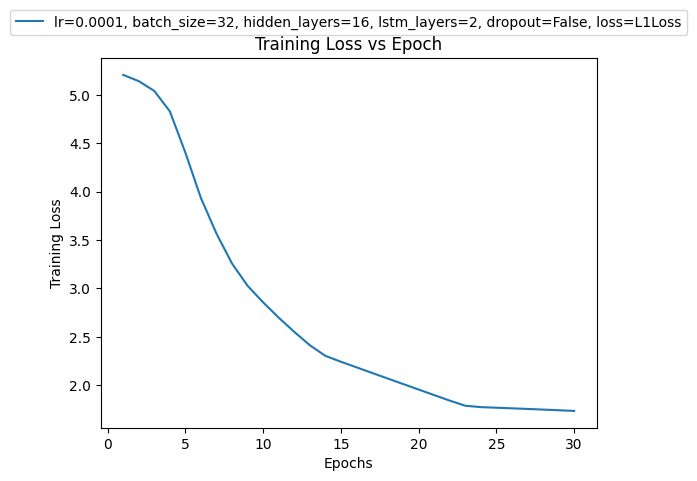

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.191866178065538
Average Test Loss: 4.159354612231255


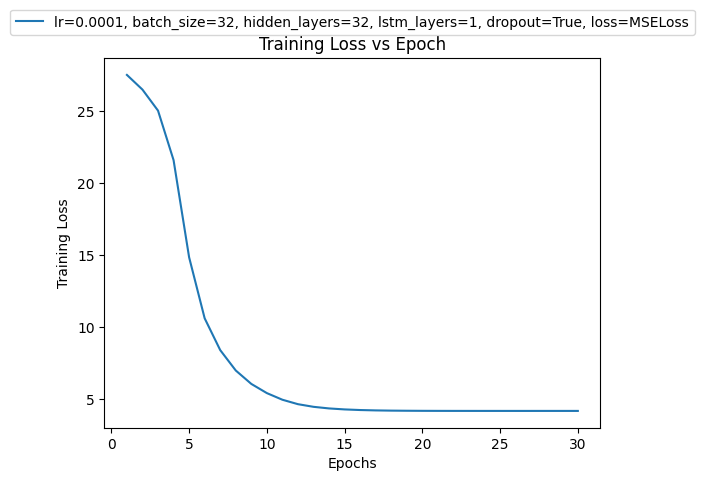

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6100983824580908
Average Test Loss: 1.5753648430109024


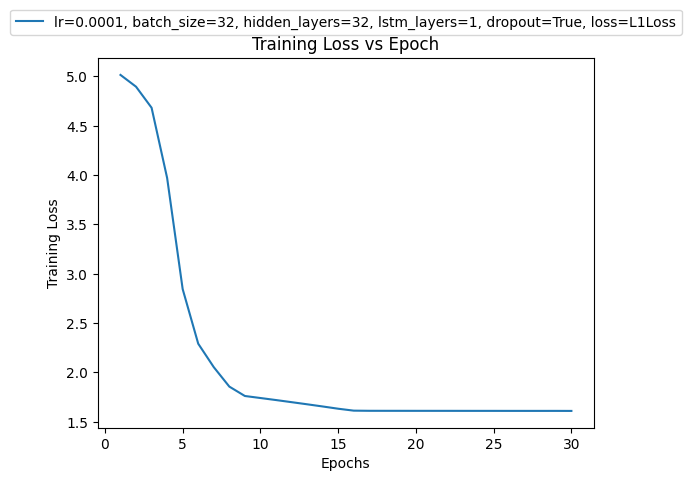

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.192171949893236
Average Test Loss: 4.15884493291378


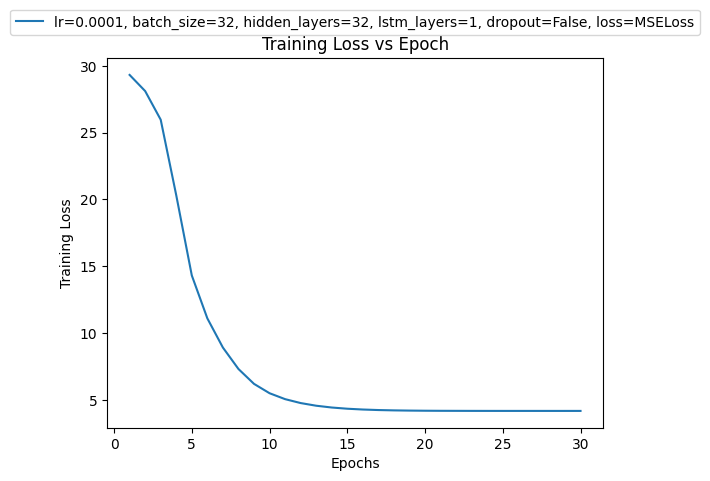

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6112057995051146
Average Test Loss: 1.5768331959843636


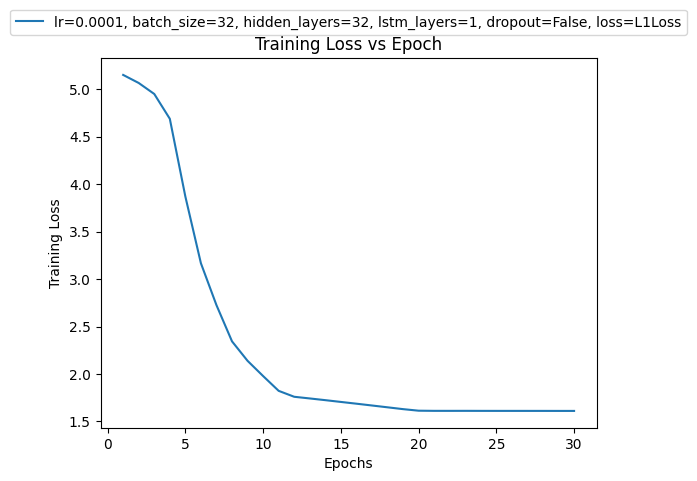

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.192447233945131
Average Test Loss: 4.159159734845161


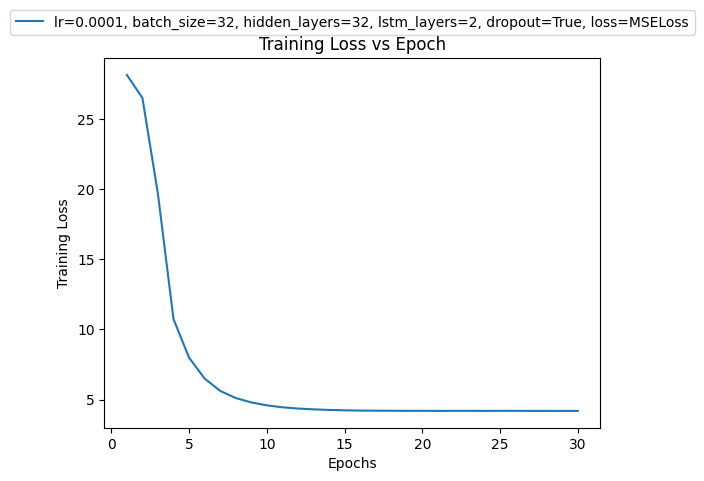

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6102563347667456
Average Test Loss: 1.5725088715553284


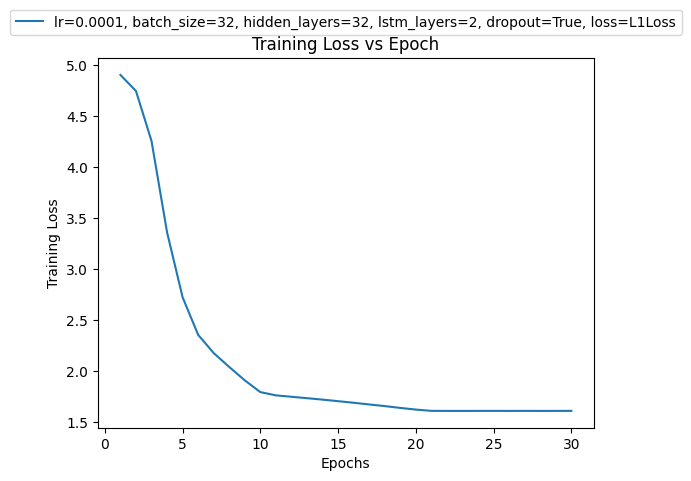

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.192358627915382
Average Test Loss: 4.158513635396957


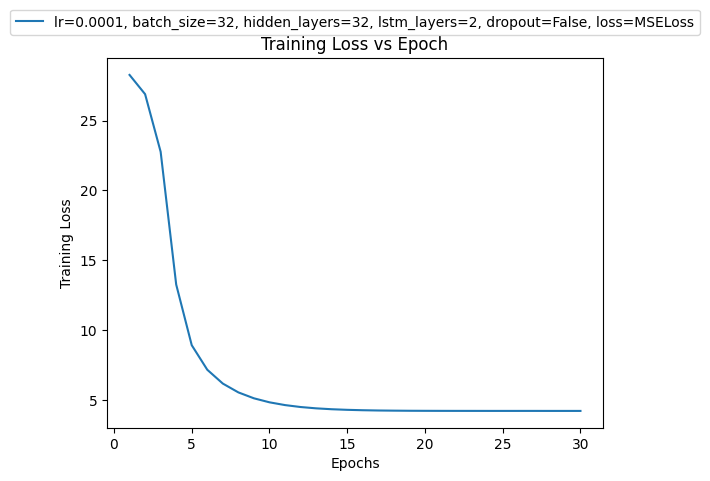

Epochs: 30, Learning Rate: 0.0001, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6082397680729628
Average Test Loss: 1.572660632431507


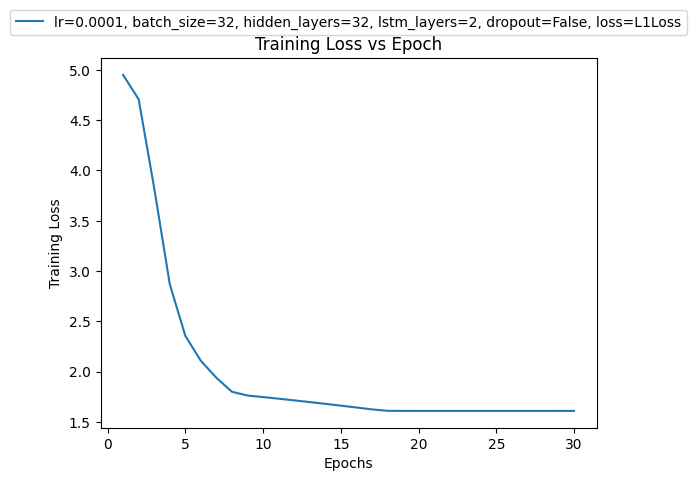

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 5.160700893029571
Average Test Loss: 4.988854326307774


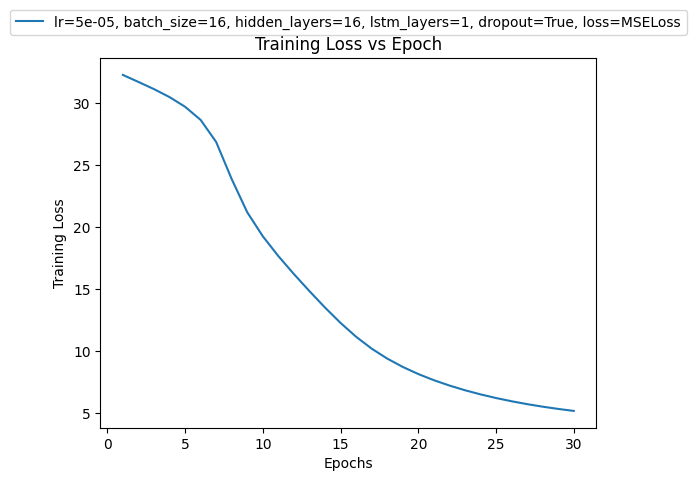

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6975620985031128
Average Test Loss: 1.6623756140470505


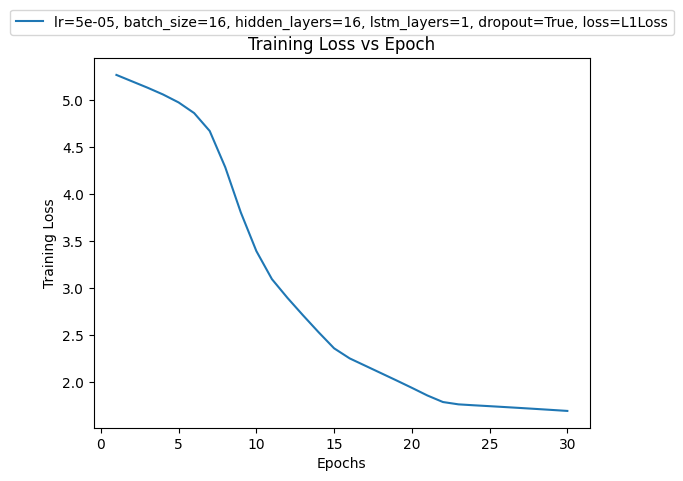

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.278412661515176
Average Test Loss: 4.237244755029678


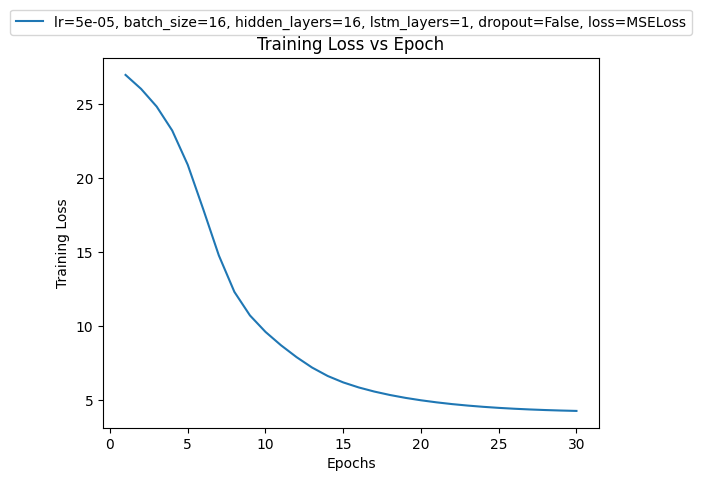

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.76540313847363
Average Test Loss: 1.7324326932430267


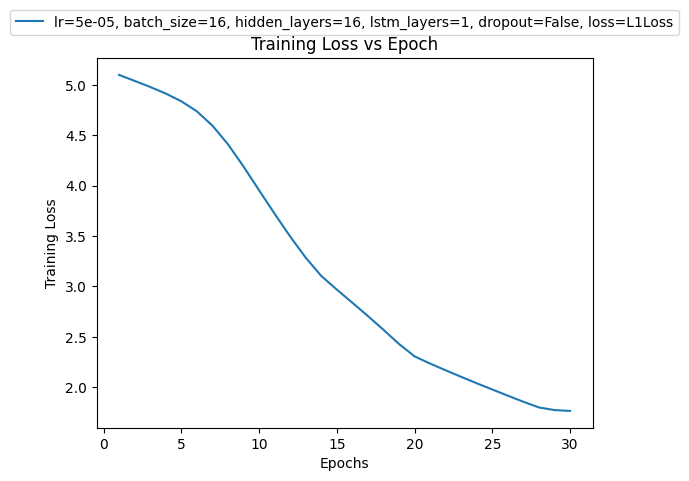

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.602765887975693
Average Test Loss: 4.4818205162882805


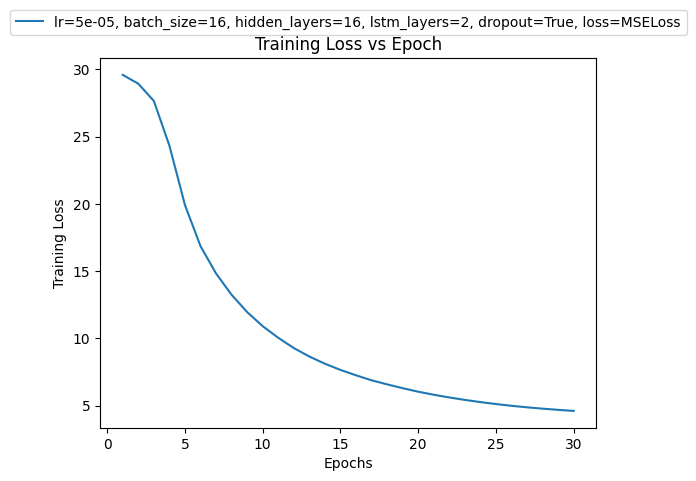

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.696264530532062
Average Test Loss: 1.6576571352779865


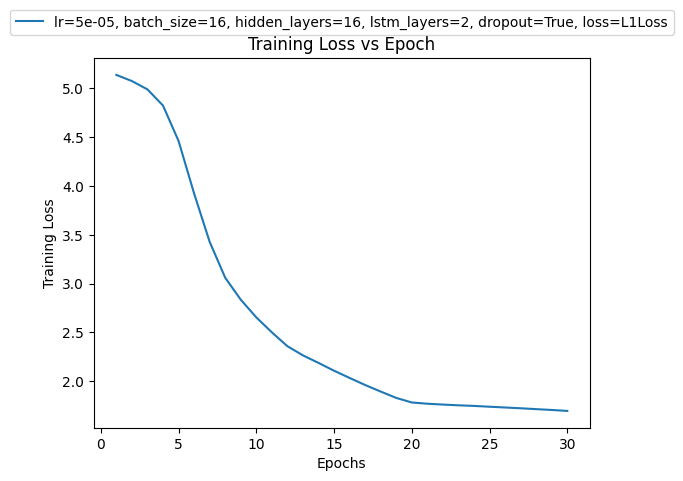

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.600579040125012
Average Test Loss: 4.486491546034813


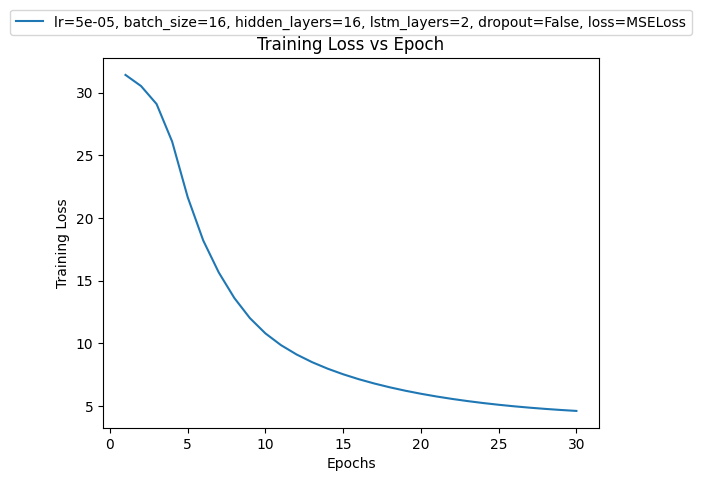

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6896698102355003
Average Test Loss: 1.6511327773332596


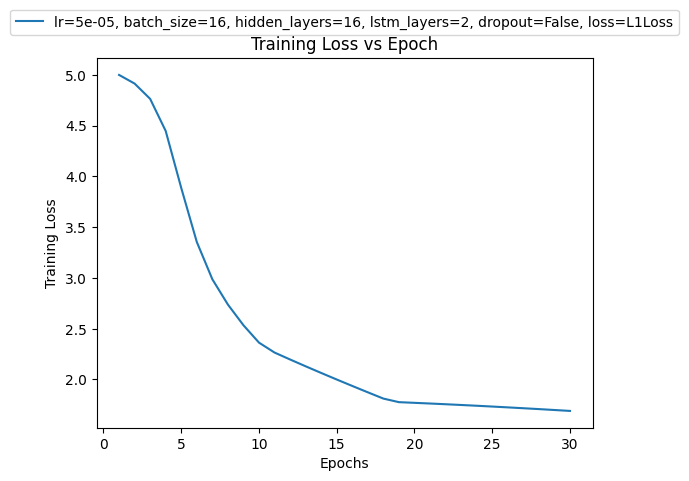

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.190814211033285
Average Test Loss: 4.165886364877224


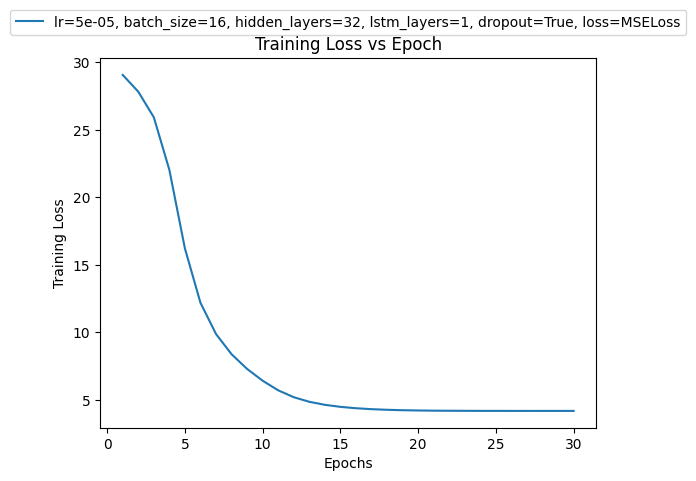

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6087347227148712
Average Test Loss: 1.5726543068885803


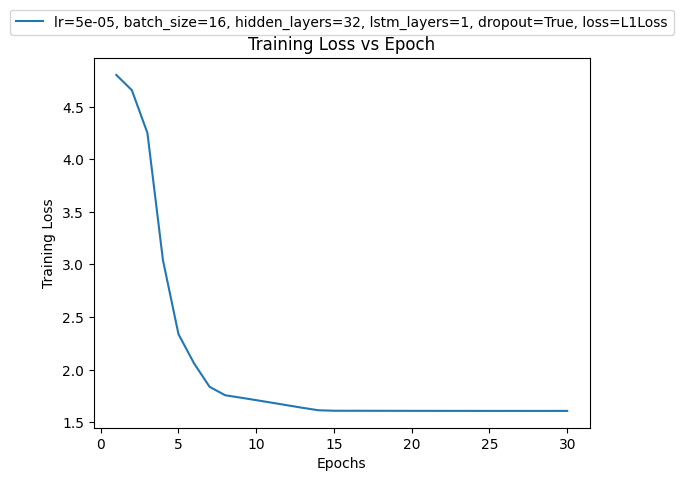

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.1911205826327205
Average Test Loss: 4.162589468061924


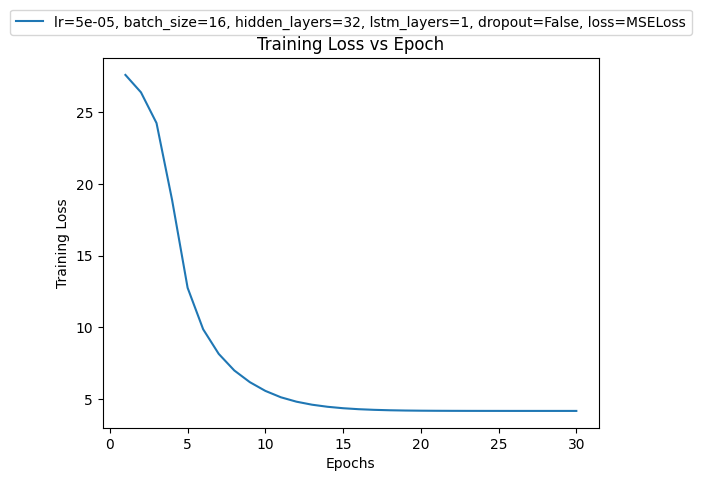

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6103767426684499
Average Test Loss: 1.5756308324635029


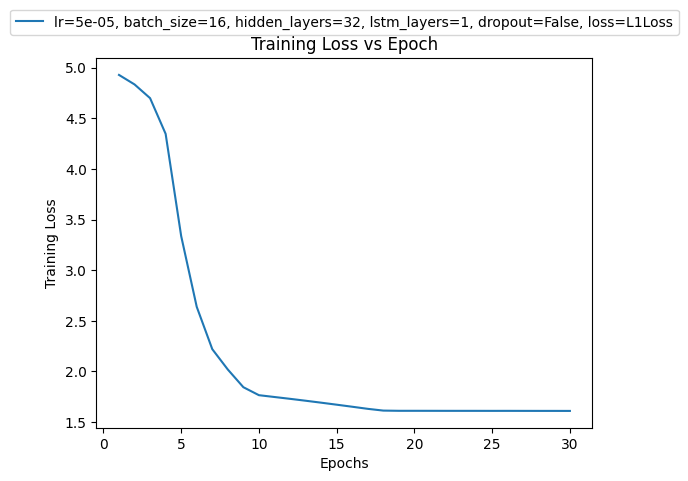

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.194144667126238
Average Test Loss: 4.158516298979521


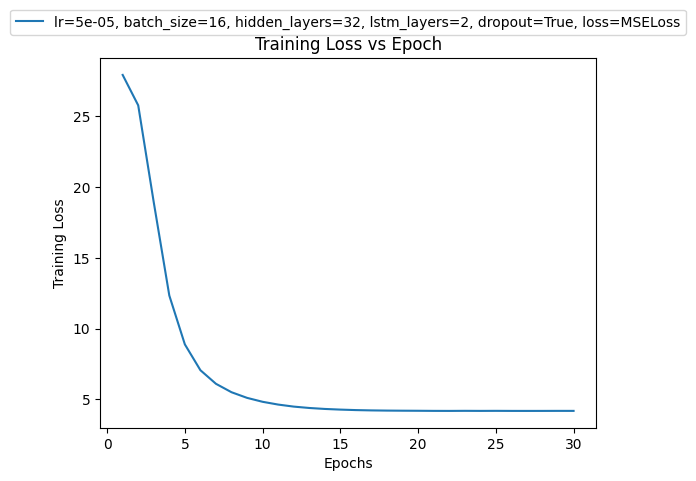

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6106868996284902
Average Test Loss: 1.5725671462714672


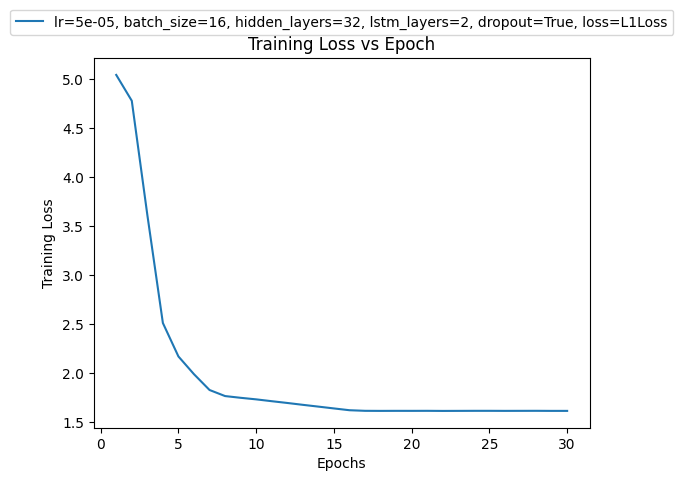

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.1925129890441895
Average Test Loss: 4.15834902971983


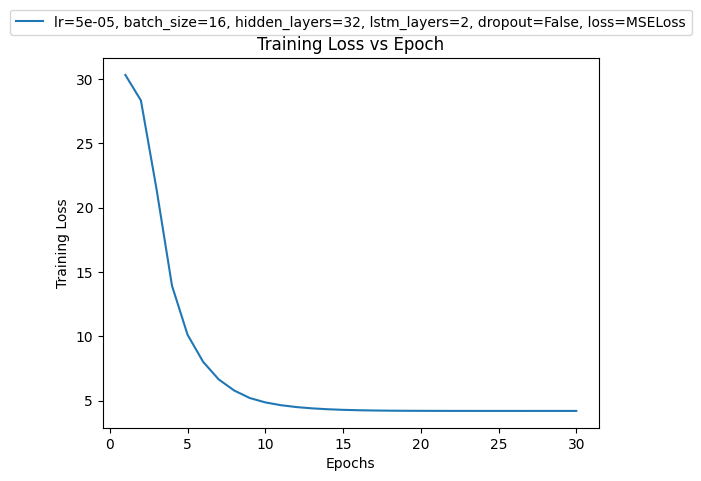

Epochs: 30, Learning Rate: 5e-05, Batch Size: 16, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6082503674551845
Average Test Loss: 1.5726253762841225


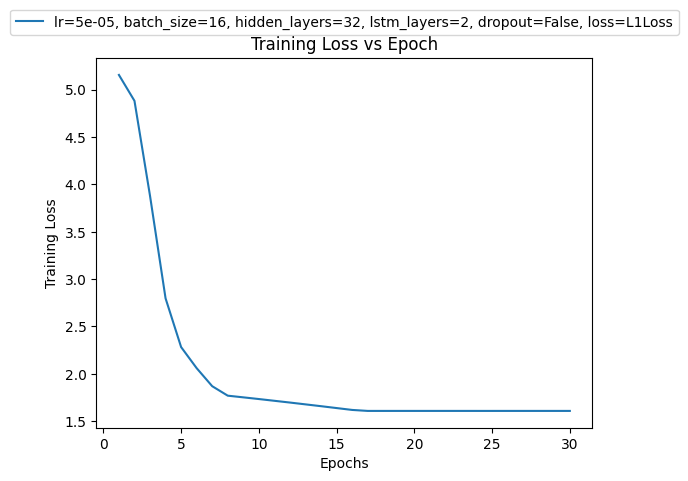

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 11.050409719347954
Average Test Loss: 10.598841786384583


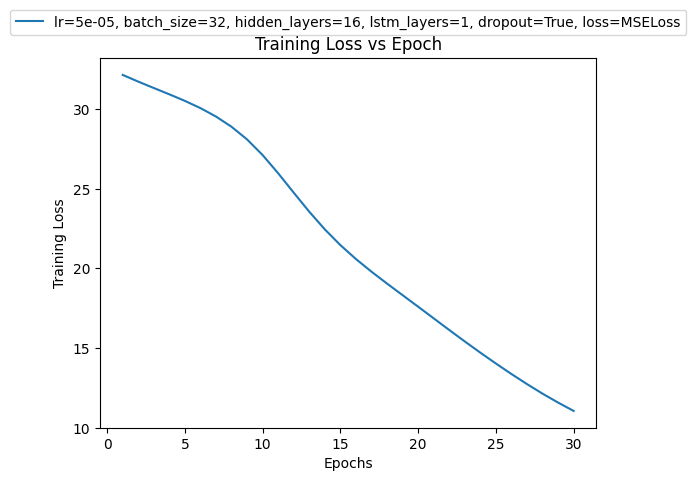

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 2.314614664763212
Average Test Loss: 2.256523847579956


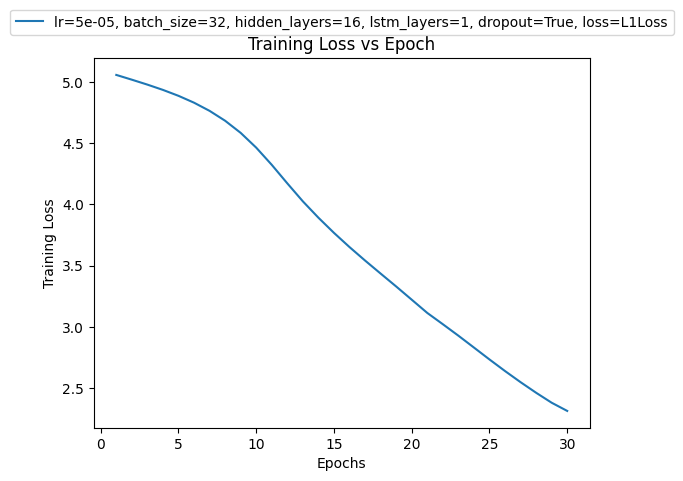

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 8.677764736115932
Average Test Loss: 8.336176186800003


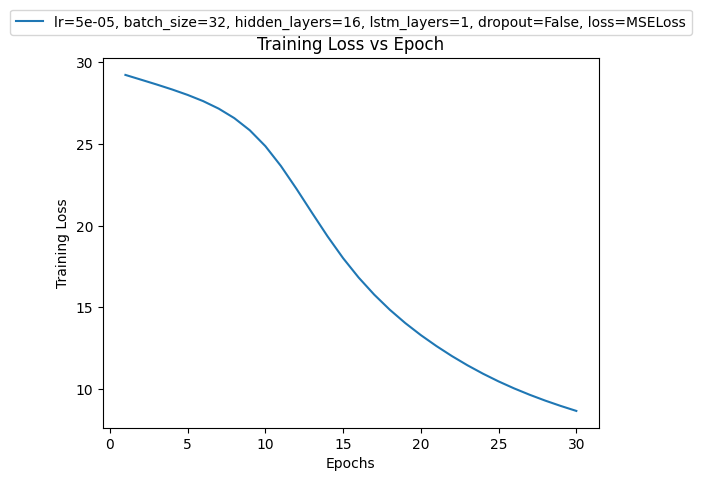

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 2.192402834072709
Average Test Loss: 2.140596464276314


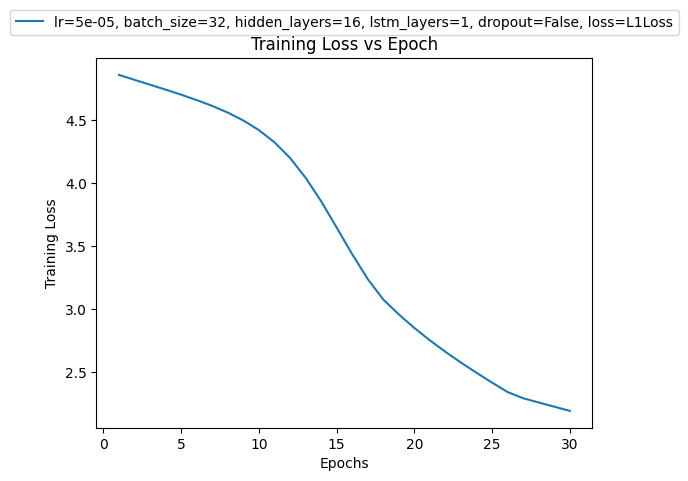

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 6.878615524619818
Average Test Loss: 6.620407581329346


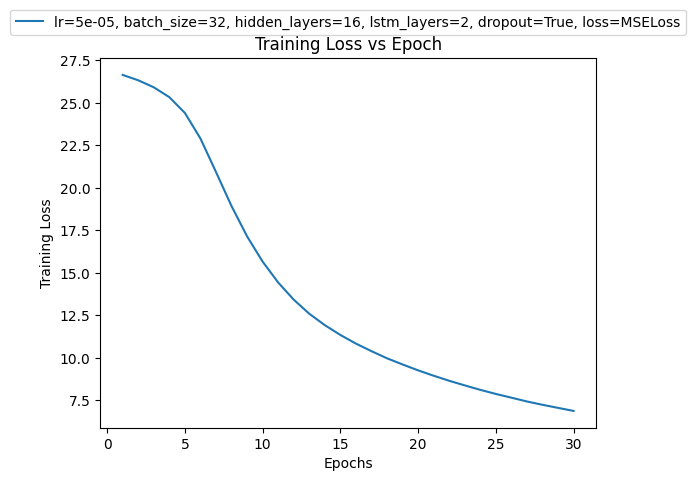

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 2.0720333885401487
Average Test Loss: 2.0179241374135017


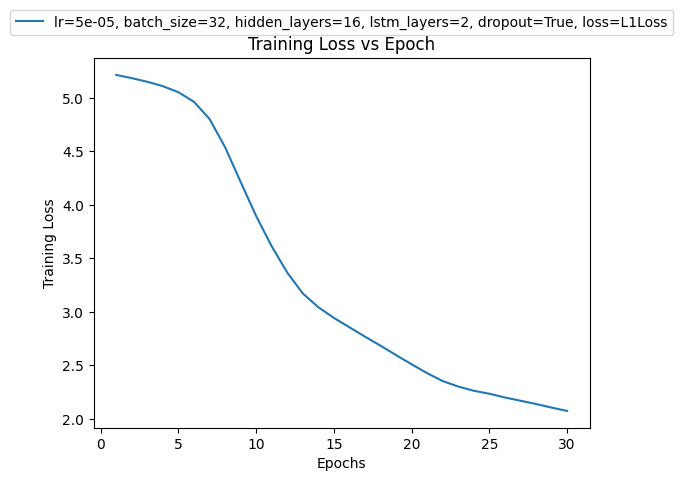

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 7.4683607667684555
Average Test Loss: 7.189761579036713


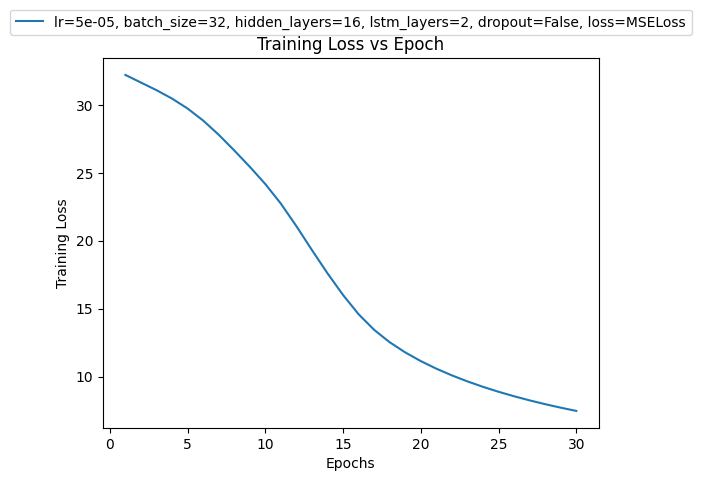

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 16, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 2.0011061299592257
Average Test Loss: 1.9504916816949844


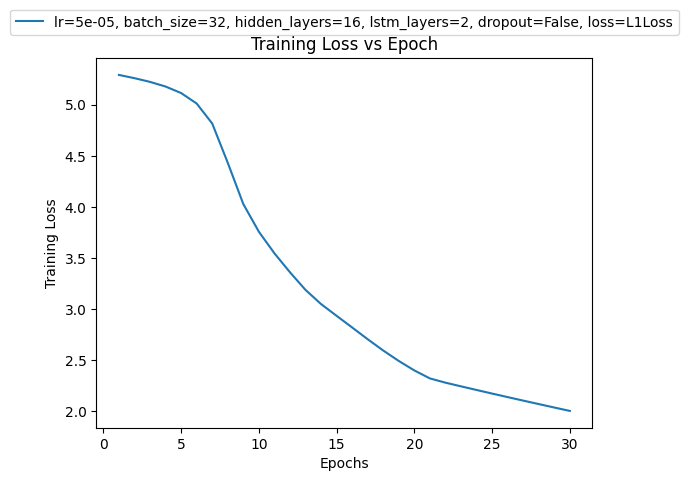

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.4610446989536285
Average Test Loss: 4.364292845129967


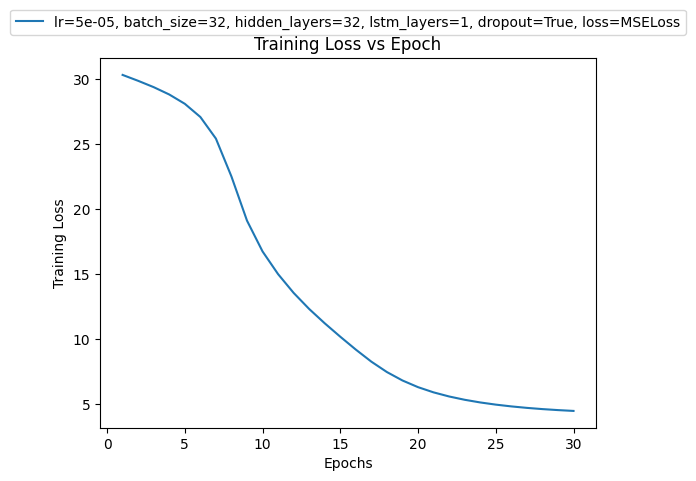

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6464201360940933
Average Test Loss: 1.6066247150301933


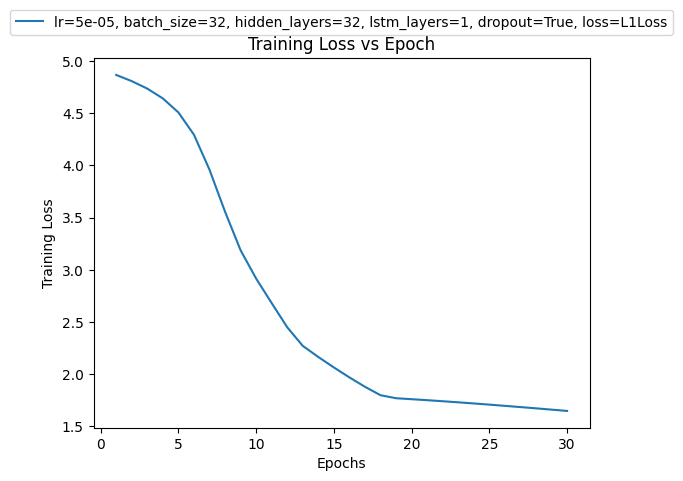

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.479586251080036
Average Test Loss: 4.390312507748604


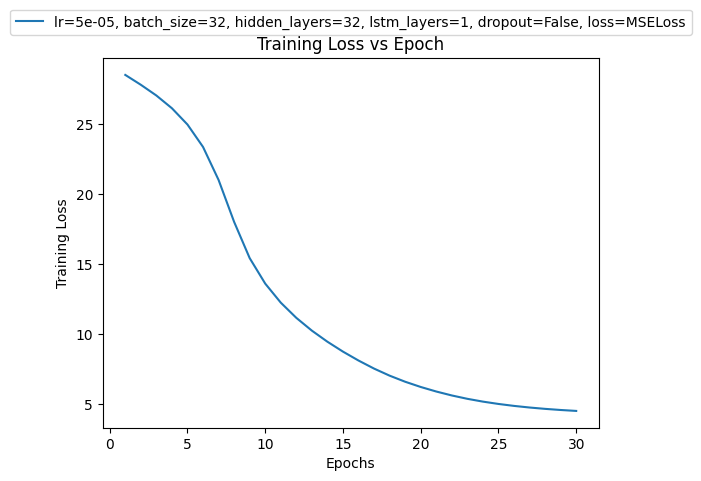

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 1, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.7372865490615368
Average Test Loss: 1.701871581375599


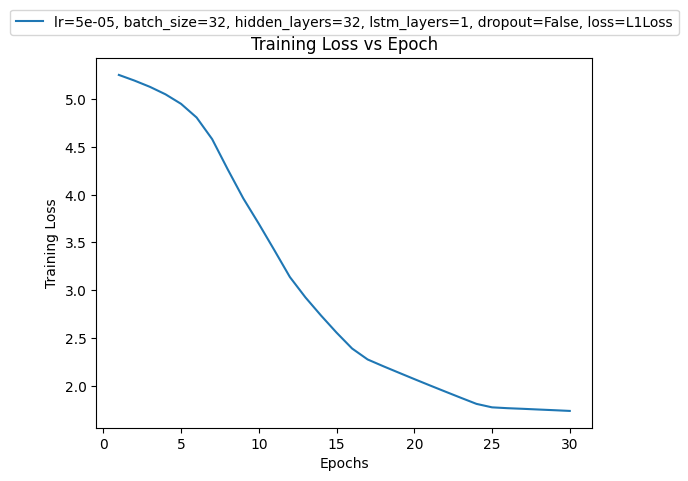

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: MSELoss
Training Loss at the last epoch: 4.2421132363379
Average Test Loss: 4.181090712547302


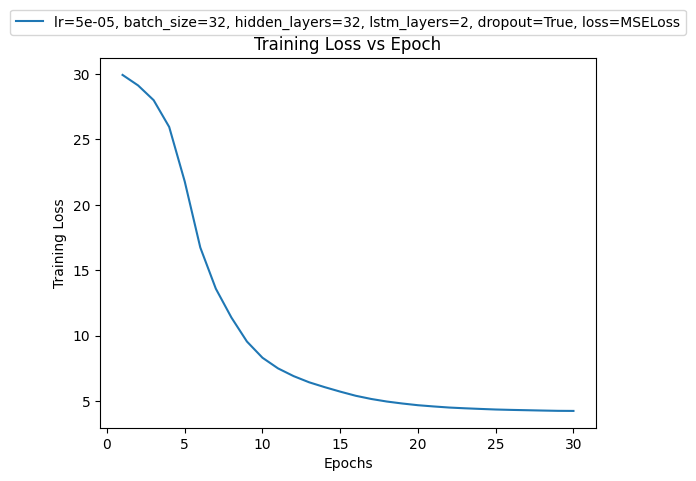

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: True, Loss Function: L1Loss
Training Loss at the last epoch: 1.6138035226613283
Average Test Loss: 1.5727621540427208


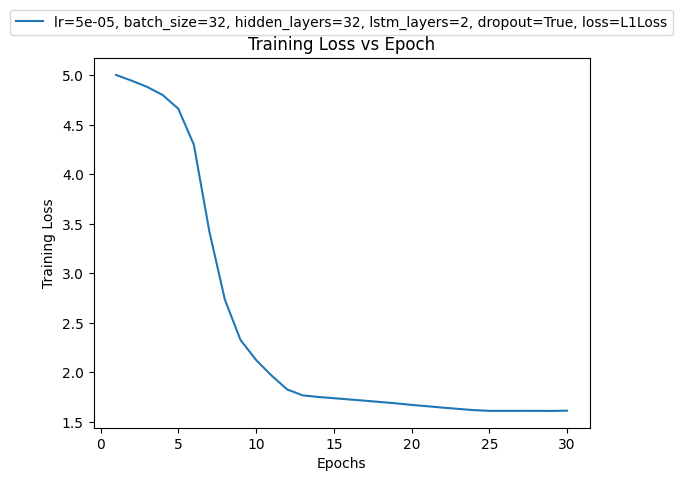

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: MSELoss
Training Loss at the last epoch: 4.308807294815779
Average Test Loss: 4.238362215459347


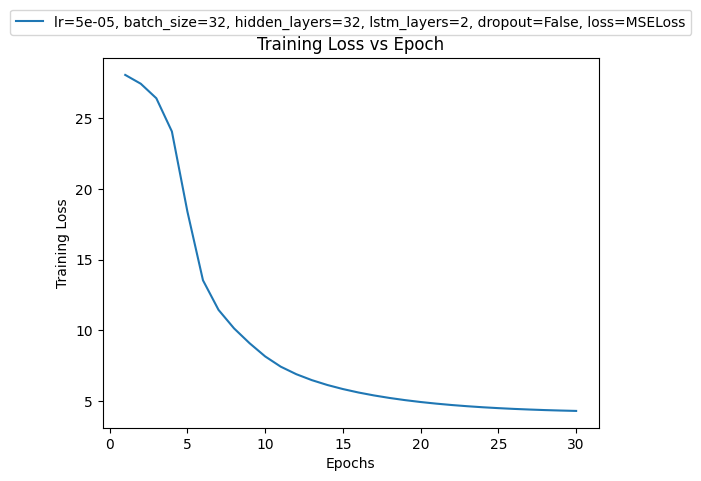

Epochs: 30, Learning Rate: 5e-05, Batch Size: 32, Hidden Layers: 32, LSTM Layers: 2, Dropout: False, Loss Function: L1Loss
Training Loss at the last epoch: 1.6209005005657673
Average Test Loss: 1.580378532409668


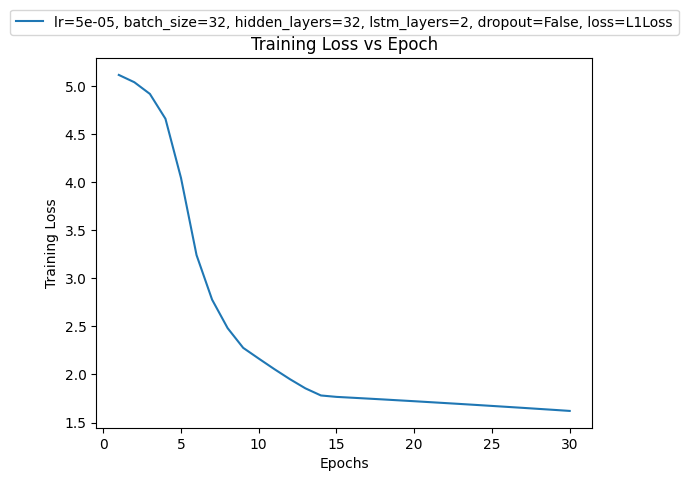

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

# Assume you have defined train_dataset, test_dataset, res_gs, and res_pred

class CpGPredictor(nn.Module):
    def __init__(self, input_size=1, output_size=1, lstm_hidden=32, lstm_layers=1, dropout=False):
        super(CpGPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True, dropout=0.2 if dropout else 0)
        self.classifier = nn.Linear(lstm_hidden, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.classifier(x)
        return x

def train_model(model, train_loader, optimizer, loss_fn, epochs):
    train_loss_values = []
    epoch_numbers = []
    t_loss = 0.0
    for epoch in range(epochs):

        for batch in train_data_loader:
            #TODO complete training loop

            optimizer.zero_grad()
            predictions = model(batch[:][0].view(-1,128,1)).reshape(-1)
            loss = loss_fn(predictions, batch[:][1])
            loss.backward()
            optimizer.step()

            # Accumulate the training loss
            t_loss += loss.item()
        average_loss = t_loss / len(train_data_loader)
        train_loss_values.append(average_loss)
        epoch_numbers.append(epoch + 1)
        t_loss = 0.0
    return model, train_loss_values, epoch_numbers

def evaluate_model(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in test_loader:
            y_pred = model(batch[0].view(-1, 128, 1)).reshape(-1)
            loss = loss_fn(y_pred, batch[1])
            total_loss += loss.item()
            predictions.extend(y_pred.tolist())
            true_values.extend(batch[1].tolist())
    average_loss = total_loss / len(test_loader)
    return average_loss, predictions, true_values

# Hyperparameters
batch_sizes = [16, 32]
learning_rates = [0.0001, 0.00005]
lstm_hidden = [16, 32]
lstm_layers = [1, 2]
dropout_options = [True, False]
loss_functions = [nn.MSELoss(), nn.L1Loss()]

# Training and Evaluation Loop
for (learning_rate, batch_size, lstm_hidden, lstm_layer, dropout_option, loss_fn) in itertools.product(
        learning_rates, batch_sizes, lstm_hidden, lstm_layers, dropout_options, loss_functions):

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = CpGPredictor(lstm_hidden=lstm_hidden, lstm_layers=lstm_layer, dropout=dropout_option)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    model, train_loss_values, epoch_numbers = train_model(model, train_data_loader, optimizer, loss_fn, 30)

    # Evaluation
    test_loss, predictions, true_values = evaluate_model(model, test_data_loader, loss_fn)

    # Print and visualize results
    print(f'Epochs: {30}, Learning Rate: {learning_rate}, Batch Size: {batch_size}, Hidden Layers: {lstm_hidden}, LSTM Layers: {lstm_layer}, Dropout: {dropout_option}, Loss Function: {type(loss_fn).__name__}')
    print(f'Training Loss at the last epoch: {train_loss_values[-1]}')
    print(f'Average Test Loss: {test_loss}')

    # Plot the training loss vs epoch
    plt.plot(range(1, 30 + 1), train_loss_values, label=f'lr={learning_rate}, batch_size={batch_size}, hidden_layers={lstm_hidden}, lstm_layers={lstm_layer}, dropout={dropout_option}, loss={type(loss_fn).__name__}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs Epoch')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1)
    plt.show()


### **Analysis of tuning hyperparameters**


The intention was to understand how altering this specific hyperparameter affects the convergence rate and stability of the model. The analysis involved fixing all other parameters and isolating one parameter at a time.

**1. Loss Function** [Chosen Parameter: MAE Loss or L1 Loss]

MSE loss is sensitive to outliers. Since the sequence generation is random, we can have a sequence that has lot of CG pairs which can be outliers in our example. Additionally, we do not have any negative values in our data, thus we can go ahead with MAE or L1 loss.

**2. Hidden layers** [Chosen Parameter: 32]

A deeper network with 32 hidden layers converged faster and stably as compared to a network with 16 hidden layers. This was observed fromm the training losses. Though the architecture with 32 hidden layers converged better, it did not seem to overfit as the test loss was minimal.

**3. LSTM Layers** [Chosen Parameter: 2]

A architecture with 2 layers performed better than the one with 1 hidden layers. The test loss was also minimal for the architecture with 2 layers.

**4. Dropout** [Chosen Parameter: True]

Including dropout had a better performance. This could be due to the regularization effect of dropout that increases the model's generalizability.

**5. Learning Rate** [Chosen Parameter: 0.001]

Using a learning rate of 0.001 helped model converge faster without the gradients overshooting as compared to using a learning rate of 0.0005.


**6. Batch Size** [Chosen Parameter: 32]

The training loss of model with batch size 32 is much lower than the training loss of model with batch size 16. When checked for overfitting, the test losses are minimal in both settings. As a result we go ahead with batch size of 32.



# Part 2: what if the DNA sequences are not the same length

In [ ]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [ ]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))

    #step 2
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train)))
    #step3
    y_dna_seqs = [] # use count_cpgs here to generate labels with temp generated in step2
    for seq in temp:
      y_dna_seqs.append(count_cpgs(seq))

    return X_dna_seqs_train, y_dna_seqs


min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.FloatTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)


# this will be a collate_fn for dataloader to pad sequence
class PadSequence:
    def __call__(self, batch):
        sequences, labels = zip(*batch)
        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
        padded_sequences = torch.nn.functional.pad(padded_sequences, (0, 128 - padded_sequences.size(1)))
        return padded_sequences, torch.FloatTensor(labels)

train_dataset = MyDataset(train_x, train_y)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, collate_fn=PadSequence())

test_dataset = MyDataset(test_x, test_y)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, collate_fn=PadSequence())


In [ ]:
# TODO complete the rest

# some config
LSTM_HIDDEN = 32
LSTM_LAYER = 1
batch_size = 32
learning_rate = 0.0001
epoch_num = 30

In [ ]:
# init model / loss function / optimizer etc.

import torch.optim as optim

model = CpGPredictor()
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# training (you can modify the code below)
t_loss = 0.0
model.train()
model.zero_grad()
for epoch in range(epoch_num):
    for batch in train_data_loader:
        #TODO complete training loop
        optimizer.zero_grad()
        predictions = model(batch[:][0].view(-1,128,1)).reshape(-1)

        loss = loss_fn(predictions, batch[:][1])
        loss.backward()
        optimizer.step()
        # Accumulate the training loss
        t_loss += loss.item()
    average_loss = t_loss / len(train_data_loader)
    print("Loss at epoch %d:  %f" % (epoch, average_loss))
    t_loss = 0.0

Loss at epoch 0:  3.787587
Loss at epoch 1:  3.758104
Loss at epoch 2:  3.728122
Loss at epoch 3:  3.693791
Loss at epoch 4:  3.650809
Loss at epoch 5:  3.589522
Loss at epoch 6:  3.479973
Loss at epoch 7:  3.173375
Loss at epoch 8:  2.479363
Loss at epoch 9:  2.023105
Loss at epoch 10:  1.851102
Loss at epoch 11:  1.721093
Loss at epoch 12:  1.600125
Loss at epoch 13:  1.549375
Loss at epoch 14:  1.548228
Loss at epoch 15:  1.547341
Loss at epoch 16:  1.546447
Loss at epoch 17:  1.545535
Loss at epoch 18:  1.544607
Loss at epoch 19:  1.543661
Loss at epoch 20:  1.542698
Loss at epoch 21:  1.541719
Loss at epoch 22:  1.540722
Loss at epoch 23:  1.539708
Loss at epoch 24:  1.538677
Loss at epoch 25:  1.537627
Loss at epoch 26:  1.536558
Loss at epoch 27:  1.535469
Loss at epoch 28:  1.534356
Loss at epoch 29:  1.533217


In [ ]:
# eval (you can modify the code below)
model.eval()

res_gs = []
res_pred = []

total_test_loss = 0.0

for batch in test_data_loader:
  with torch.no_grad():
        y_pred = model(batch[:][0].view(-1,128,1)).reshape(-1)
        test_loss = loss_fn(y_pred, batch[:][1])
        total_test_loss += test_loss.item()

        res_gs.extend(batch[:][1].tolist())
        res_pred.extend(y_pred.tolist())
average_test_loss = total_test_loss / len(test_data_loader)
print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 1.6365120261907578


In [ ]:
# TODO complete evaluation of the model

from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Regression Metrics")

print("Mean Absolute Error: ", mean_absolute_error(res_gs, res_pred))
print("Mean Squared Error ", mean_squared_error(res_gs, res_pred))

# We can also treat it as a classification problem and compute precision, recall F1 scores

from sklearn.metrics import precision_score, recall_score
res_gs = [int(round(val)) for val in res_gs]
res_pred = [int(round(val)) for val in res_pred]

precision = precision_score(res_gs, res_pred, average='micro')
print("Precision: ", precision)
recall = recall_score(res_gs, res_pred, average='micro')
print("Recall: ", recall)

Regression Metrics
Mean Absolute Error:  1.6365120597183704
Mean Squared Error  4.006240566289835
Precision:  0.18359375
Recall:  0.18359375


### Test on individual sample

In [ ]:
sequence = 'NACGNACGTTNNATCNACGT'

X_dna_seqs_test = [list(dnaseq_to_intseq(list(sequence))) + [0] * (128 - len(sequence))]
Y_dna_seqs_test = [count_cpgs]

In [ ]:
test_dataset = MyDataset(X_dna_seqs_test, Y_dna_seqs_test)

In [ ]:
test_pred = model(test_dataset[:][0].view(-1,128,1)).view(-1)
test_pred

tensor([3.4486], grad_fn=<ViewBackward0>)

### Save model

In [ ]:
torch.save(model, 'model.pth')